In [1]:
import os 
import json
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
mpl.style.use('./paper.mcstyle')

import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn

from CASBI.utils.create_dataframe import rescale
from CASBI.sbi.conf_yaml import generate_data_yaml, generate_training_yaml
from CASBI.sbi.gen_halo import  gen_halo_Nsubhalos, gen_halo
from CASBI.sbi.inference import run_inference, load_posterior, infer_observation, evaluate_posterior, calibrarion

In [14]:
x = np.load(os.path.join(inference_dir, 'N_subhalos_data', 'x_test.npy'))
_, counts = np.unique(x, return_counts=True)

In [24]:
import numpy as np

def check_repeated_images(images):
    # Reshape images to 2D, with each row being an image
    reshaped_images = images.reshape(images.shape[0], -1)
    
    # Find unique images and their counts
    unique_images, counts = np.unique(reshaped_images, axis=0, return_counts=True)
    
    # Check if any count is greater than 1
    is_repeated = np.any(counts > 1)
    
    return is_repeated, counts, unique_images
is_repeated, count, unique_images = check_repeated_images(x)
print(f"Is any image repeated? {is_repeated}")

Is any image repeated? True


In [27]:
unique_images.shape

(98, 4096)

In [24]:
from multiprocessing import Pool
import time
#loading and rescaling the data
data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
data = rescale(data, mean_and_std_path='../../data/preprocess/mean_and_std.parquet', scale_observations=True, scale_parameters=True, inverse=True) 
data =  data.drop(['gas_log10mass', 'a','redshift', 'mean_metallicity', 'std_metallicity','mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)

def gen_onehalo(data, N_subhalos, train:bool, galaxies_test:np.array, min_feh, max_feh, min_ofe, max_ofe, random_state):
    """
    Function to genereate one halo for a given number of subhalos. If train=True, the function will check if each of the sets of subhalos is already present in the test set, and if so, it will generate a new set of subhalos.
    Args:
    data (pd.DataFrame): dataframe containing the data
    N_subhalos (int): number of subhalos
    train (bool): if True, check if the set of subhalos is already present in the test set
    galaxies_test (np.array): test set of galaxies
    min_feh (float): minimum value of feh
    max_feh (float): maximum value of feh
    min_ofe (float): minimum value of ofe
    max_ofe (float): maximum value of ofe
    random_state (int): random state to generate the subhalos
    
    Returns:
    N_subhalos (int): number of subhalos
    parameters (np.array): parameters of the subhalos
    sim_data (np.array): simulated data
    galaxies (np.array): list of galaxies
    
    """
    if train==False:
        galaxies = set(data['Galaxy_name'].drop_duplicates().sample(N_subhalos, random_state=random_state))
    else:
        galaxies = set(data['Galaxy_name'].drop_duplicates().sample(N_subhalos, random_state=random_state))
    if train: #if training check wheter or not those galaxy are present in the galaxy test set 
        while (any(set(galaxies) == galaxy_in_testset for galaxy_in_testset in galaxies_test)):
            print('matched galaxies, try again')
            print('galaxies', set(galaxies))
            print('test galaxies', galaxies_test)
            galaxies = data['Galaxy_name'].drop_duplicates().sample(N_subhalos, random_state=int(time.time()))
    parameters =  data[data['Galaxy_name'].isin(galaxies)].drop(['feh', 'ofe', 'Galaxy_name'], axis=1).drop_duplicates().values.T
    sorted_index = np.argsort(parameters[0], )[::-1] #orders the parameters in descending order of star mass
    parameters = (parameters[:,sorted_index]).reshape(-1)
    galaxy_data = data[data['Galaxy_name'].isin(galaxies)].values
    histogram_galaxy, _, _ = np.histogram2d(galaxy_data[:, 0], galaxy_data[:, 1], bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
    sim_data =  np.expand_dims(np.log10(histogram_galaxy + 1e-6 +1), axis=0)
    return N_subhalos, parameters, sim_data, galaxies

def gen_halo_Nsubhalos(data:pd.DataFrame, n_test:int, n_train:int, max_subhalos:int=100, ):
    """
    Generate the galaxy halo to train the inference on the number of subhalos N.
    Args:
    data (pd.DataFrame): dataframe with observation and parameters already rescaled to physical values
    output_dir (str): path to the output directory where to store the data, important to separete it from the gen_halo function output directory
    n_test (int): number of test samples, it will be used to generate n_test samples for each number of subhalos from 2 to max_subhalos
    n_train (int): number of training samples, it will be used to generate n_train samples for each number of subhalos from 2 to max_subhalos
    max_subhalos (int): maximum number of subhalos
    
    Returns:
    N_subhalos_test (np.array): number of subhalos for the test set
    parameters_test (np.array): parameters of the subhalos for the test set
    x_test (np.array): simulated data for the test set
    galaxies_test (np.array): list of galaxies for the test set
    N_subhalos_0 (np.array): number of subhalos for the first test set element
    x_0 (np.array): simulated data for the first test set element
    N_subhalos (np.array): number of subhalos for the training set
    parameters (np.array): parameters of the subhalos for the training set
    x (np.array): simulated data for the training set
    galaxies_training (np.array): list of galaxies for the training set
    """

    # data = pd.read_parquet(data_file)
    # data = rescale(data, mean_and_std_path=rescale_file, scale_observations=True, scale_parameters=True, inverse=True) 
    # data =  data.drop(['gas_log10mass', 'a','redshift', 'mean_metallicity', 'std_metallicity','mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
    min_feh, max_feh = min(data['feh']), max(data['feh'])
    min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])

    arr = np.concatenate([np.repeat(i, n_test) for i in range(2, max_subhalos)]) #generate n_test samples for each number of subhalos from 2 to max_subhalos
    np.random.shuffle(arr)
    # Create a pool of workers
    with Pool() as pool:
        # Map the function to the data
        results = pool.starmap(gen_onehalo, [(data, n_subhalos, 0, None, min_feh, max_feh, min_ofe, max_ofe, int(time.time())) for e, n_subhalos in enumerate(arr)]) #n_subhalos is passed also as random state to generate the subhalos
        
    # Unpack the results
    N_subhalos_test, parameters_test, x_test, galaxies_test = zip(*results)
    N_subhalos_test = np.array(N_subhalos_test).reshape((len(N_subhalos_test), 1))  

    #take the first test set element as x_0 and theta_0    
    galaxies_0 = galaxies_test[0]
    # data_to_plot_halos = data[data['Galaxy_name'].isin(galaxies_0)].to_parquet('./halos_0.parquet')
    N_subhalos_0 = N_subhalos_test[0]
    x_0 =  x_test[0]
        
    arr = np.concatenate([np.repeat(i, n_train) for i in range(2, max_subhalos)]) #generate n_train samples for each number of subhalos from 2 to max_subhalos
    np.random.shuffle(arr)
    # Create a pool of workers
    with Pool() as pool:
        # Map the function to the data
        results = pool.starmap(gen_onehalo, [(data, n_subhalos, 1, galaxies_test, min_feh, max_feh, min_ofe, max_ofe, int(time.time())) for e, n_subhalos in enumerate(arr)]) #n_subhalos is passed also as random state to generate the subhalos

    # Unpack the results
    N_subhalos, parameters, x, galaxies_training = zip(*results)
    N_subhalos = np.array(N_subhalos).reshape((len(N_subhalos), 1))

    #save in .npy files, we remove the first element of the test set since it will be stored as x_0 and theta_0')
    print('finish prepare the data')
    
    return N_subhalos_test, parameters_test, x_test, galaxies_test, N_subhalos_0, x_0, N_subhalos, parameters, x, galaxies_training

In [26]:
int(time.time())

1717829664

In [25]:
N_subhalos_test, parameters_test, x_test, galaxies_test, N_subhalos_0, x_0, N_subhalos, parameters, x, galaxies_training = gen_halo_Nsubhalos(data, 10, 100)

finish prepare the data


In [27]:
galaxies_training = np.array(galaxies_training)
_, count =  np.unique(galaxies_training, return_counts=True)

In [28]:
len(count)

98

In [2]:
! cd ../../../../data/vgiusepp/complete_inference/; tree

.
├── N_subhalos_data
│   ├── N_subhalos.npy
│   ├── N_subhalos_0.npy
│   ├── N_subhalos_test.npy
│   ├── galaxy_0.npy
│   ├── parameters_0.npy
│   ├── x.npy
│   ├── x_0.npy
│   └── x_test.npy
├── N_subhalos_data.yaml
├── N_subhalos_data.yaml.save
├── N_subhalos_training.yaml
├── data
│   ├── theta.npy
│   ├── theta_0.npy
│   ├── theta_test.npy
│   ├── x.npy
│   ├── x_0.npy
│   └── x_test.npy
├── data.yaml
├── inference_N_subhalos.npy
├── inference_galaxy.npy
├── inference_parameters.npy
├── inference_theta.npy
├── inference_theta_Nsubahalosinfo.npy
├── inference_x.npy
└── training.yaml

2 directories, 25 files


In [3]:
#generate the yaml file for the two inference part 
inference_dir = "../../../../data/vgiusepp/complete_inference/" #where all the data and yaml file will be stored

yaml_N_subhalos_data_path = os.path.join(inference_dir, "N_subhalos_data.yaml")
yamL_N_subhalos_training_path = os.path.join(inference_dir, "N_subhalos_training.yaml")

yaml_data_path = os.path.join(inference_dir, "data.yaml")
yaml_training_path = os.path.join(inference_dir, "training.yaml")

In [5]:
#Number of subhalos inference
generate_data_yaml(filepath=yaml_N_subhalos_data_path, 
                   in_dir=os.path.join(inference_dir, 'N_subhalos_data/'), #where the data are stored
                   theta_file='N_subhalos.npy',
                   thetafid_file='N_subhalos_0.npy')
generate_training_yaml(filepath=yamL_N_subhalos_training_path, output_file='./N_subhalos_NPE', hidden_feature=70, num_transforms=5)


#Subhalos properties inference
generate_data_yaml(filepath=yaml_data_path, 
                   in_dir=os.path.join(inference_dir, 'data/')) #where the data are stored
generate_training_yaml(filepath=yaml_training_path, output_file='./galaxy_NPE')

In [4]:
#loading and rescaling the data
data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
data = rescale(data, mean_and_std_path='../../data/preprocess/mean_and_std.parquet', scale_observations=True, scale_parameters=True, inverse=True) 
data =  data.drop(['gas_log10mass', 'a','redshift', 'mean_metallicity', 'std_metallicity','mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)

In [6]:
min_feh, max_feh = min(data['feh']), max(data['feh'])
min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])
#unseen galaxies to do infernce on when the whole pipeline is ready
inference_N_subhalos = 10
inference_galaxy = data['Galaxy_name'].drop_duplicates().sample(inference_N_subhalos)
inference_parameters =  data[data['Galaxy_name'].isin(inference_galaxy)].drop(['feh', 'ofe', 'Galaxy_name'], axis=1).drop_duplicates().values.T
sorted_index = np.argsort(inference_parameters[0], )[::-1] #orders the parameters in descending order of star mass
inference_parameters = (inference_parameters[:,sorted_index]).reshape(-1)
inferernce_galaxy_data = data[data['Galaxy_name'].isin(inference_galaxy)].values
histogram_galaxy, _, _ = np.histogram2d(inferernce_galaxy_data[:, 0], inferernce_galaxy_data[:, 1], bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
infererence_sim_data =  np.expand_dims(np.log10(histogram_galaxy + 1e-6 +1), axis=0)

np.save(os.path.join(inference_dir, 'inference_N_subhalos.npy'), np.array(inference_N_subhalos).reshape(1, 1))
np.save(os.path.join(inference_dir, 'inference_theta.npy'), inference_parameters)
np.save(os.path.join(inference_dir, 'inference_x.npy'), infererence_sim_data)
np.save(os.path.join(inference_dir, 'inference_galaxy.npy'), inference_galaxy.values)


In [5]:
#remove the galaxies
data = data[~data['Galaxy_name'].isin(np.load(os.path.join(inference_dir, 'inference_galaxy.npy'), allow_pickle=True))]

In [8]:
#generate halos for the training of the N_subhalos inference 
_ = gen_halo_Nsubhalos(data=data,
                       output_dir=os.path.join(inference_dir,'N_subhalos_data' ),
                       n_test=100,
                       n_train=1000,)

finish prepare the data


In [2]:
def transform(N_subhalos):
    return N_subhalos-2
    
class CustomDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=transform):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path).reshape(-1)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            label = self.transform(label) # so the labels starts from 0 instead of 2
        return image, label

inference_dir = "../../../../data/vgiusepp/analysis_hist/N_subhalos_2/" #where all the data and yaml file will be stored
batch_size = 512
path = os.path.join(inference_dir, 'N_subhalos_data/')
train_dataset = CustomDataset(images_path=path+'x.npy', labels_path=path+'N_subhalos.npy')
test_dataset = CustomDataset(images_path=path+'x_test.npy', labels_path=path+'N_subhalos_test.npy') 

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Split the original training dataset into a new training dataset and a validation dataset
# Here, we use 80% of the images for training and 20% for validation
num_train = len(train_loader.dataset)
num_val = int(0.2 * num_train)
num_train = num_train - num_val
train_dataset, val_dataset = random_split(train_loader.dataset, [num_train, num_val])

# Create DataLoaders for the new training dataset and the validation dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [3]:
from CASBI.sbi.CNN_skip import ConvNet

model = ConvNet(input_channel=1, output_dim=64)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda:5'
model =  model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
epochs=450
# Initialize lists to store the history of training and validation loss
train_loss_history = []
val_loss_history = []


best_val_loss = float('inf')  
pbar = tqdm(range(1, epochs + 1))
# Training loop with validation
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).float(), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device).float(), target.to(device)
            output = model(data)
            val_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_loss_history.append(val_loss)
    
    accuracy = 100. * correct / len(val_loader.dataset)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'classifier_best_model.pth')

    pbar.set_description(f'Epoch: {epoch} Train Loss: {train_loss:.6f} Val Loss: {val_loss:.4f} Accuracy: {accuracy:.0f}%')
    


  0%|          | 0/450 [00:00<?, ?it/s]

../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [12,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [16,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [17,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [21,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_lo

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


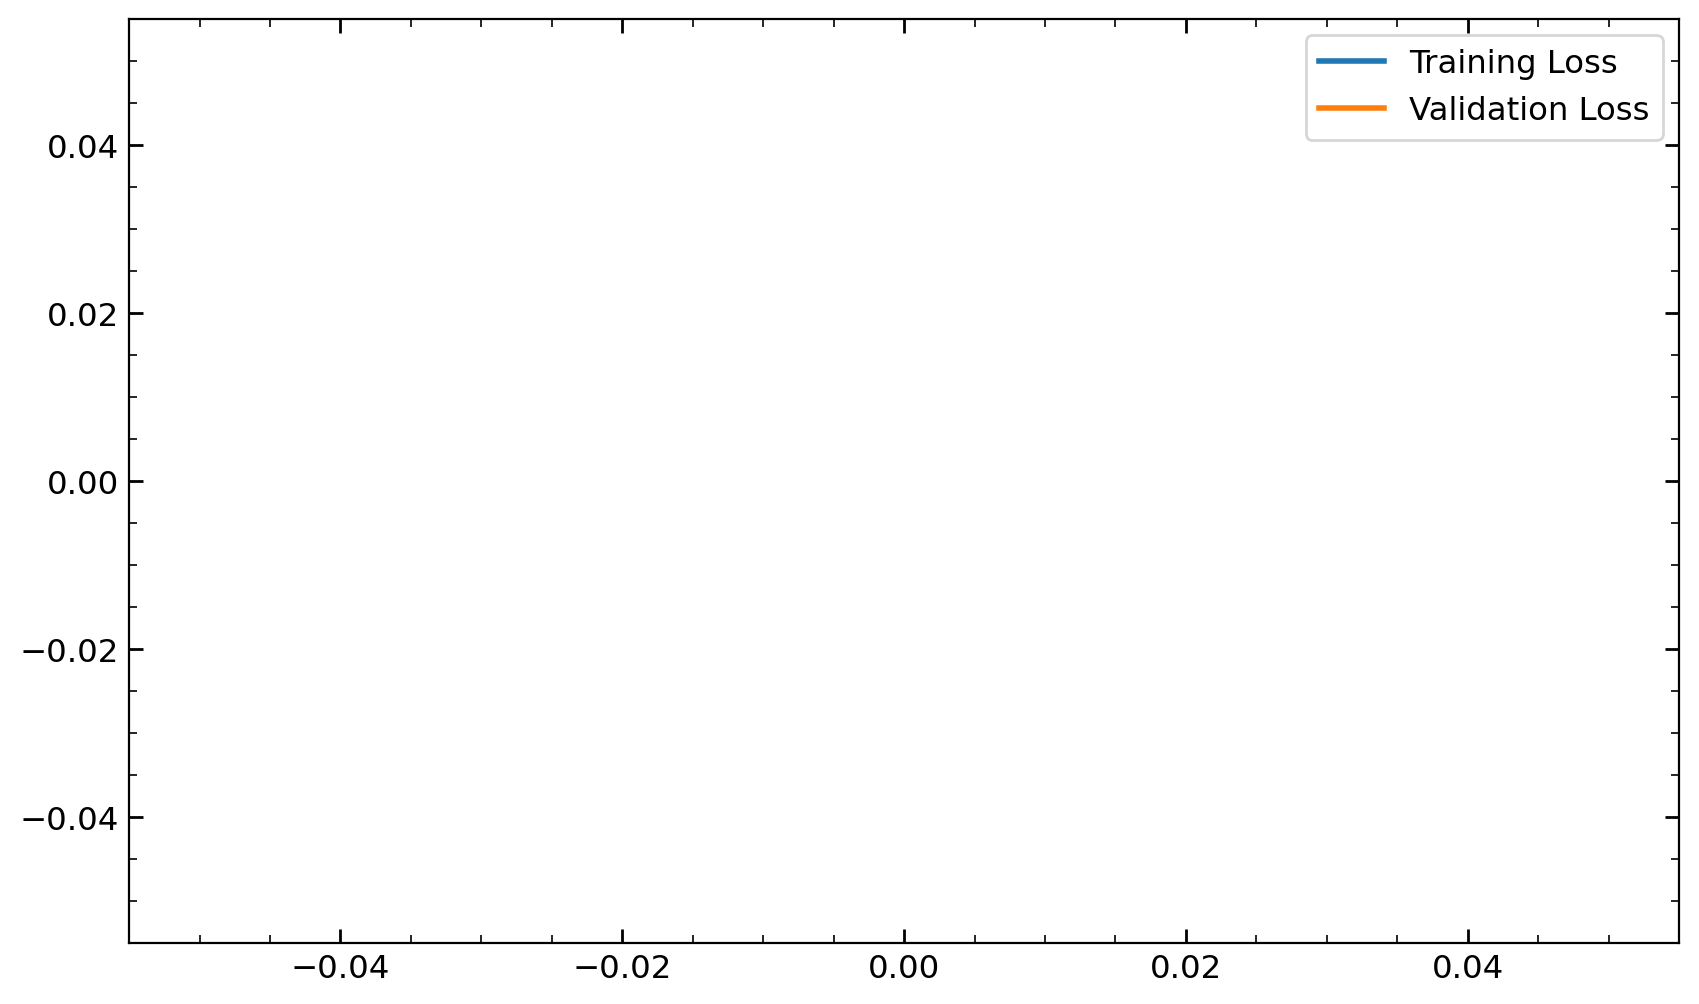

In [9]:
plt.figure()
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.show()

In [6]:
model.load_state_dict(torch.load('classifier_best_model.pth'))
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device).float(), target.to(device)
        output = model(data)
        test_loss += loss_fn(output, target).item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0060, Accuracy: 117/979 (12%)




Test set: Average loss: 0.0060, Accuracy: 117/979 (12%)



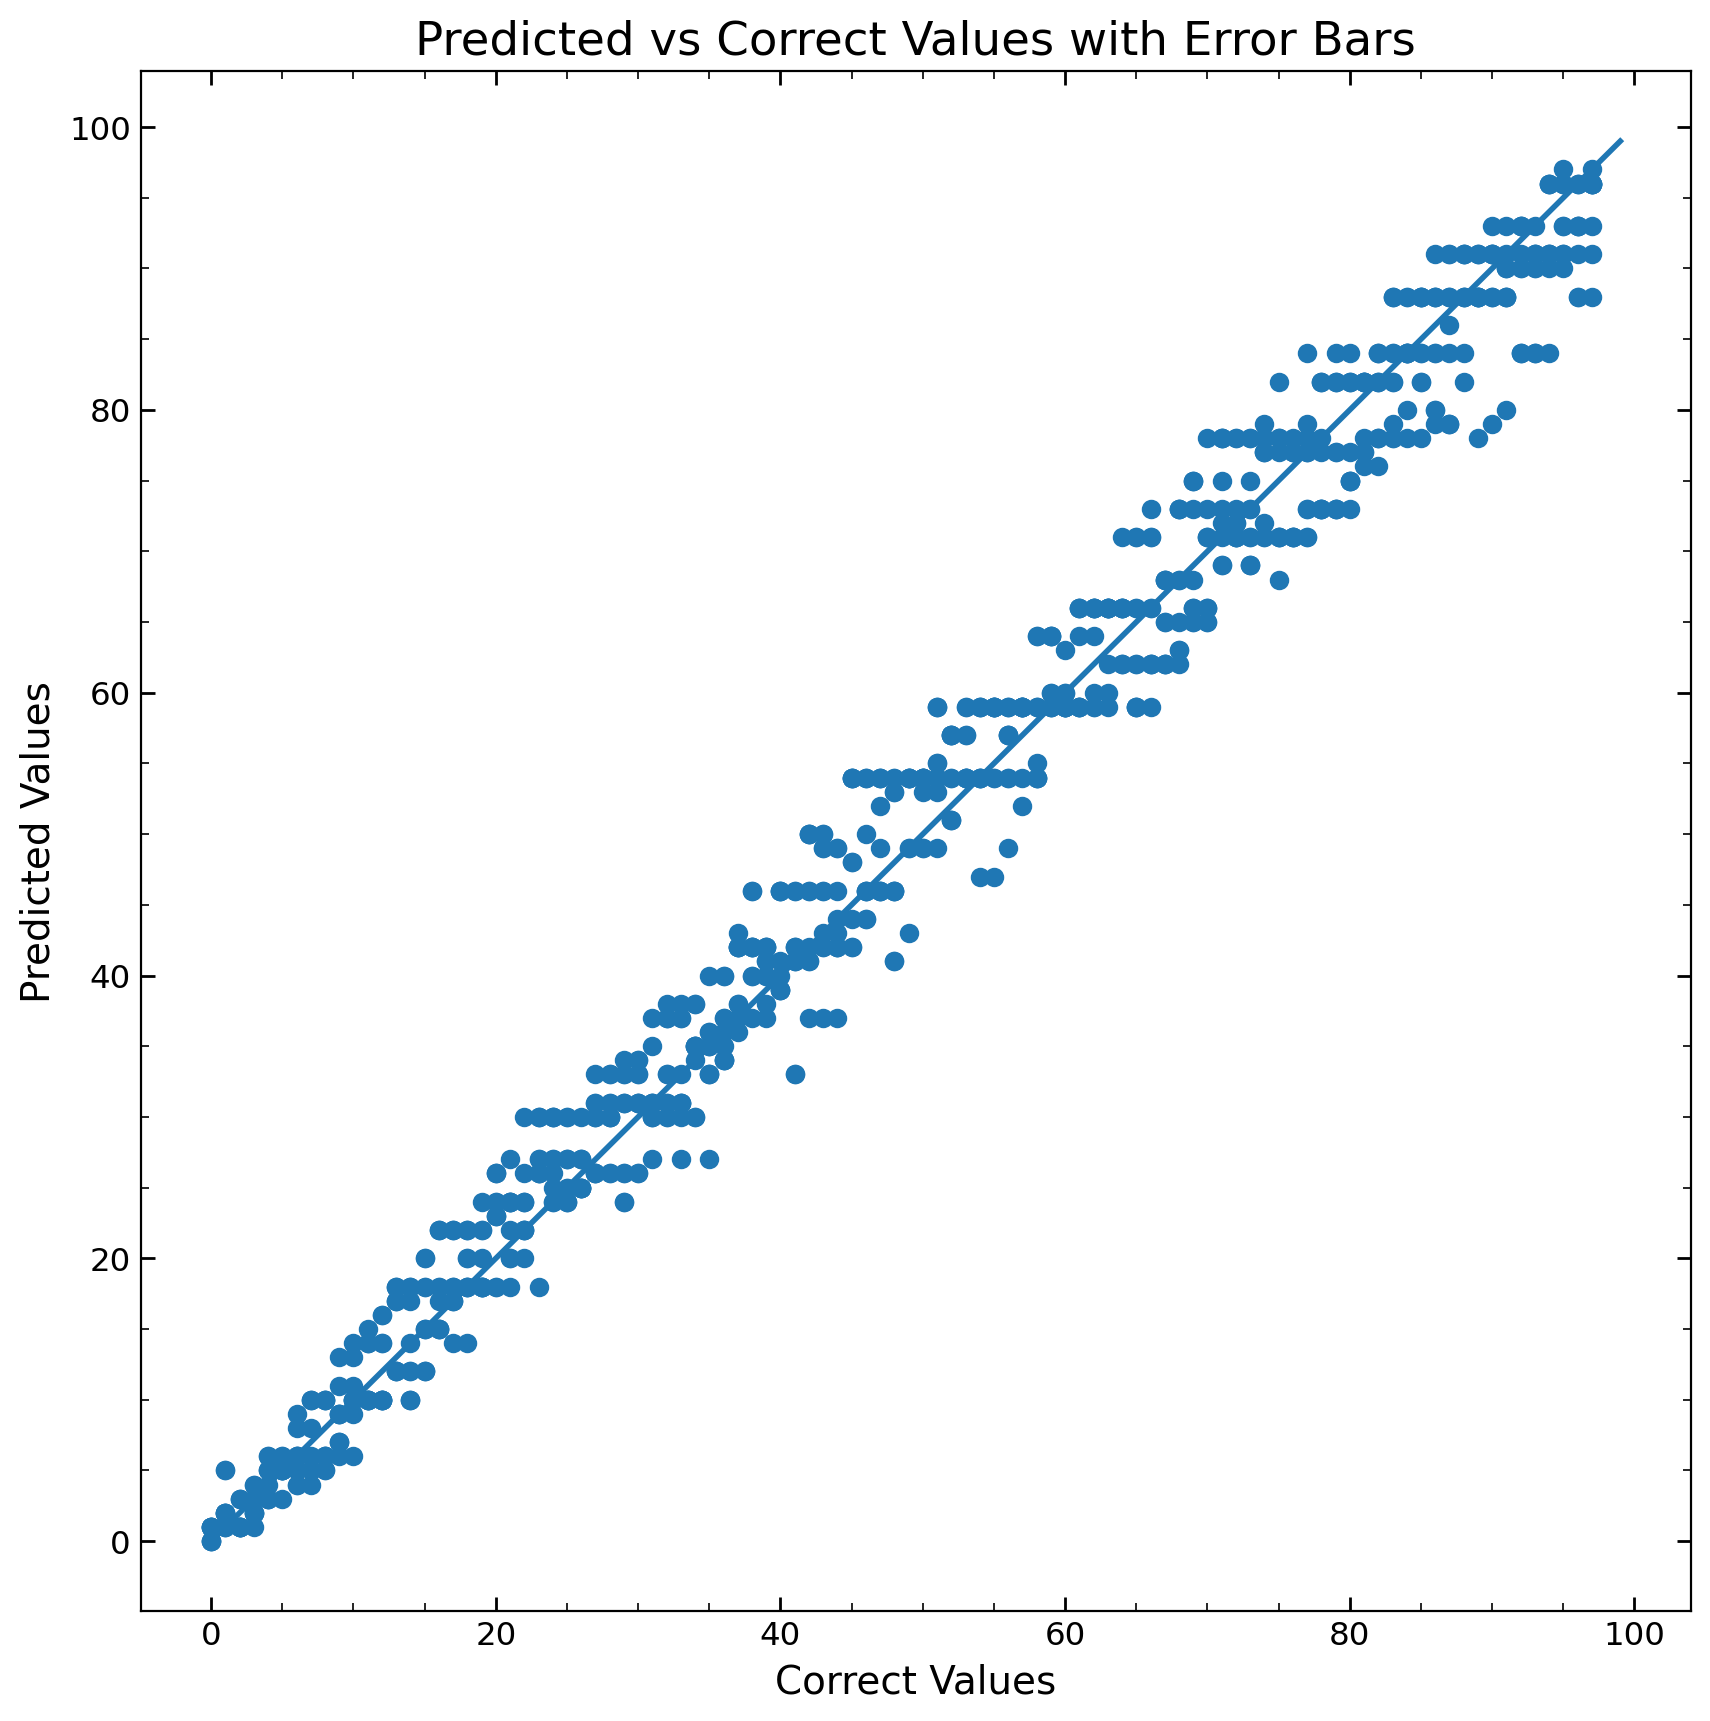

In [7]:
import matplotlib.pyplot as plt

model.eval()
test_loss = 0
correct = 0
preds = []
targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device).float(), target.to(device)
        output = model(data)
        test_loss += loss_fn(output, target).item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        preds.extend(pred.cpu().numpy())
        targets.extend(target.cpu().numpy())

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

# Calculate differences between predicted and actual values
diffs = np.array(preds) - np.array(targets)

# Calculate standard deviation of differences
std_dev = np.std(diffs)

# Plot predicted vs correct values with error bars
plt.figure(figsize=(10, 10))
# plt.errorbar(targets, preds, yerr=std_dev, fmt='o', alpha=0.5)
plt.scatter(targets, preds)
plt.plot(range(100))
plt.xlabel('Correct Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Correct Values with Error Bars')
plt.show()


In [36]:
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device).float(), target.to(device)
        print(data.shape)
        break

torch.Size([512, 1, 64, 64])


In [37]:
inference_x.unsqueeze(0).shape

torch.Size([1, 1, 64, 64])

In [41]:
model.eval()
with torch.no_grad():
    inference_x = torch.from_numpy(np.load(os.path.join(inference_dir, 'inference_x.npy')))
    inference_N_subhalos = torch.from_numpy(np.load(os.path.join(inference_dir, 'inference_N_subhalos.npy')))
    inference_x, inference_N_subhalos = inference_x.to(device).unsqueeze(0).float(), inference_N_subhalos.to(device)
    output = model(inference_x)
    pred = output.argmax(dim=1, keepdim=True)


In [42]:
pred

tensor([[8]], device='cuda:0')

In [ ]:
_ = gen_halo(data=data, output_dir=os.path.join(inference_dir,'data' ), 
             training_yaml=yaml_training_path, 
             n_test=100, n_train=10_000, N_subhalos=round(samples.mean().item()))

running gen halo
write the right prior in the training.yaml file
finish prepare the data


In [ ]:
#train the posterior
run_inference(yaml_training_path, yaml_data_path)

#load the posterior from pkl file 
posterior = load_posterior('./galaxy_NPE_posterior.pkl')

INFO:root:MODEL INFERENCE CLASS: NPE
/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 2.


 Neural network successfully converged after 76 epochs.

INFO:root:Training model 2 / 2.
/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/user_input_checks.py:435: UserWarning: Mismatch between the device of the data fed to the embedding_net and the device of the embedding_net's weights. Fed data has device 'cpu' vs embedding_net weights have device 'cuda:0'. Automatically switching the embedding_net's device to 'cpu', which could otherwise be done manually using the line `embedding_net.to('cpu')`.
  warnings.warn(


 Neural network successfully converged after 205 epochs.

/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 99.72399115562439 seconds to train models.
INFO:root:Saving model to .


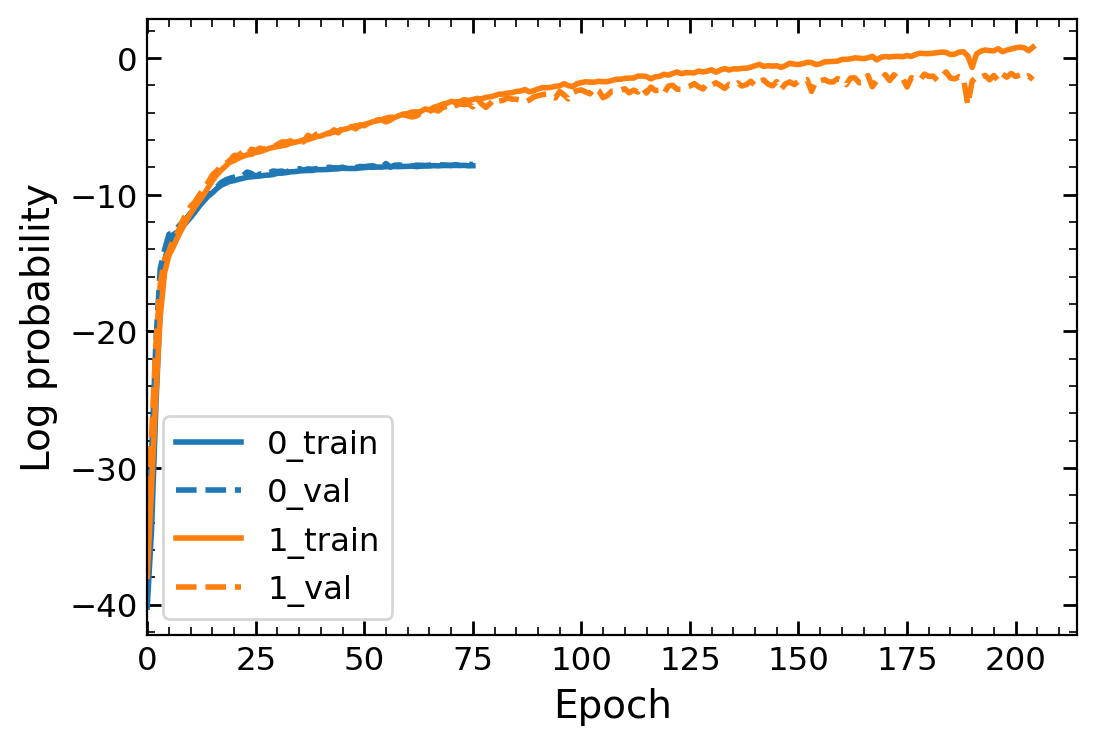

In [ ]:
# Open the JSON file
with open('galaxy_NPE_summary.json', 'r') as f:
    # Load the data from the file
    summaries = json.load(f)
    
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 9 posterior samples:   0%|          | 0/9 [00:00<?, ?it/s]

Drawing 9991 posterior samples:   0%|          | 0/9991 [00:00<?, ?it/s]

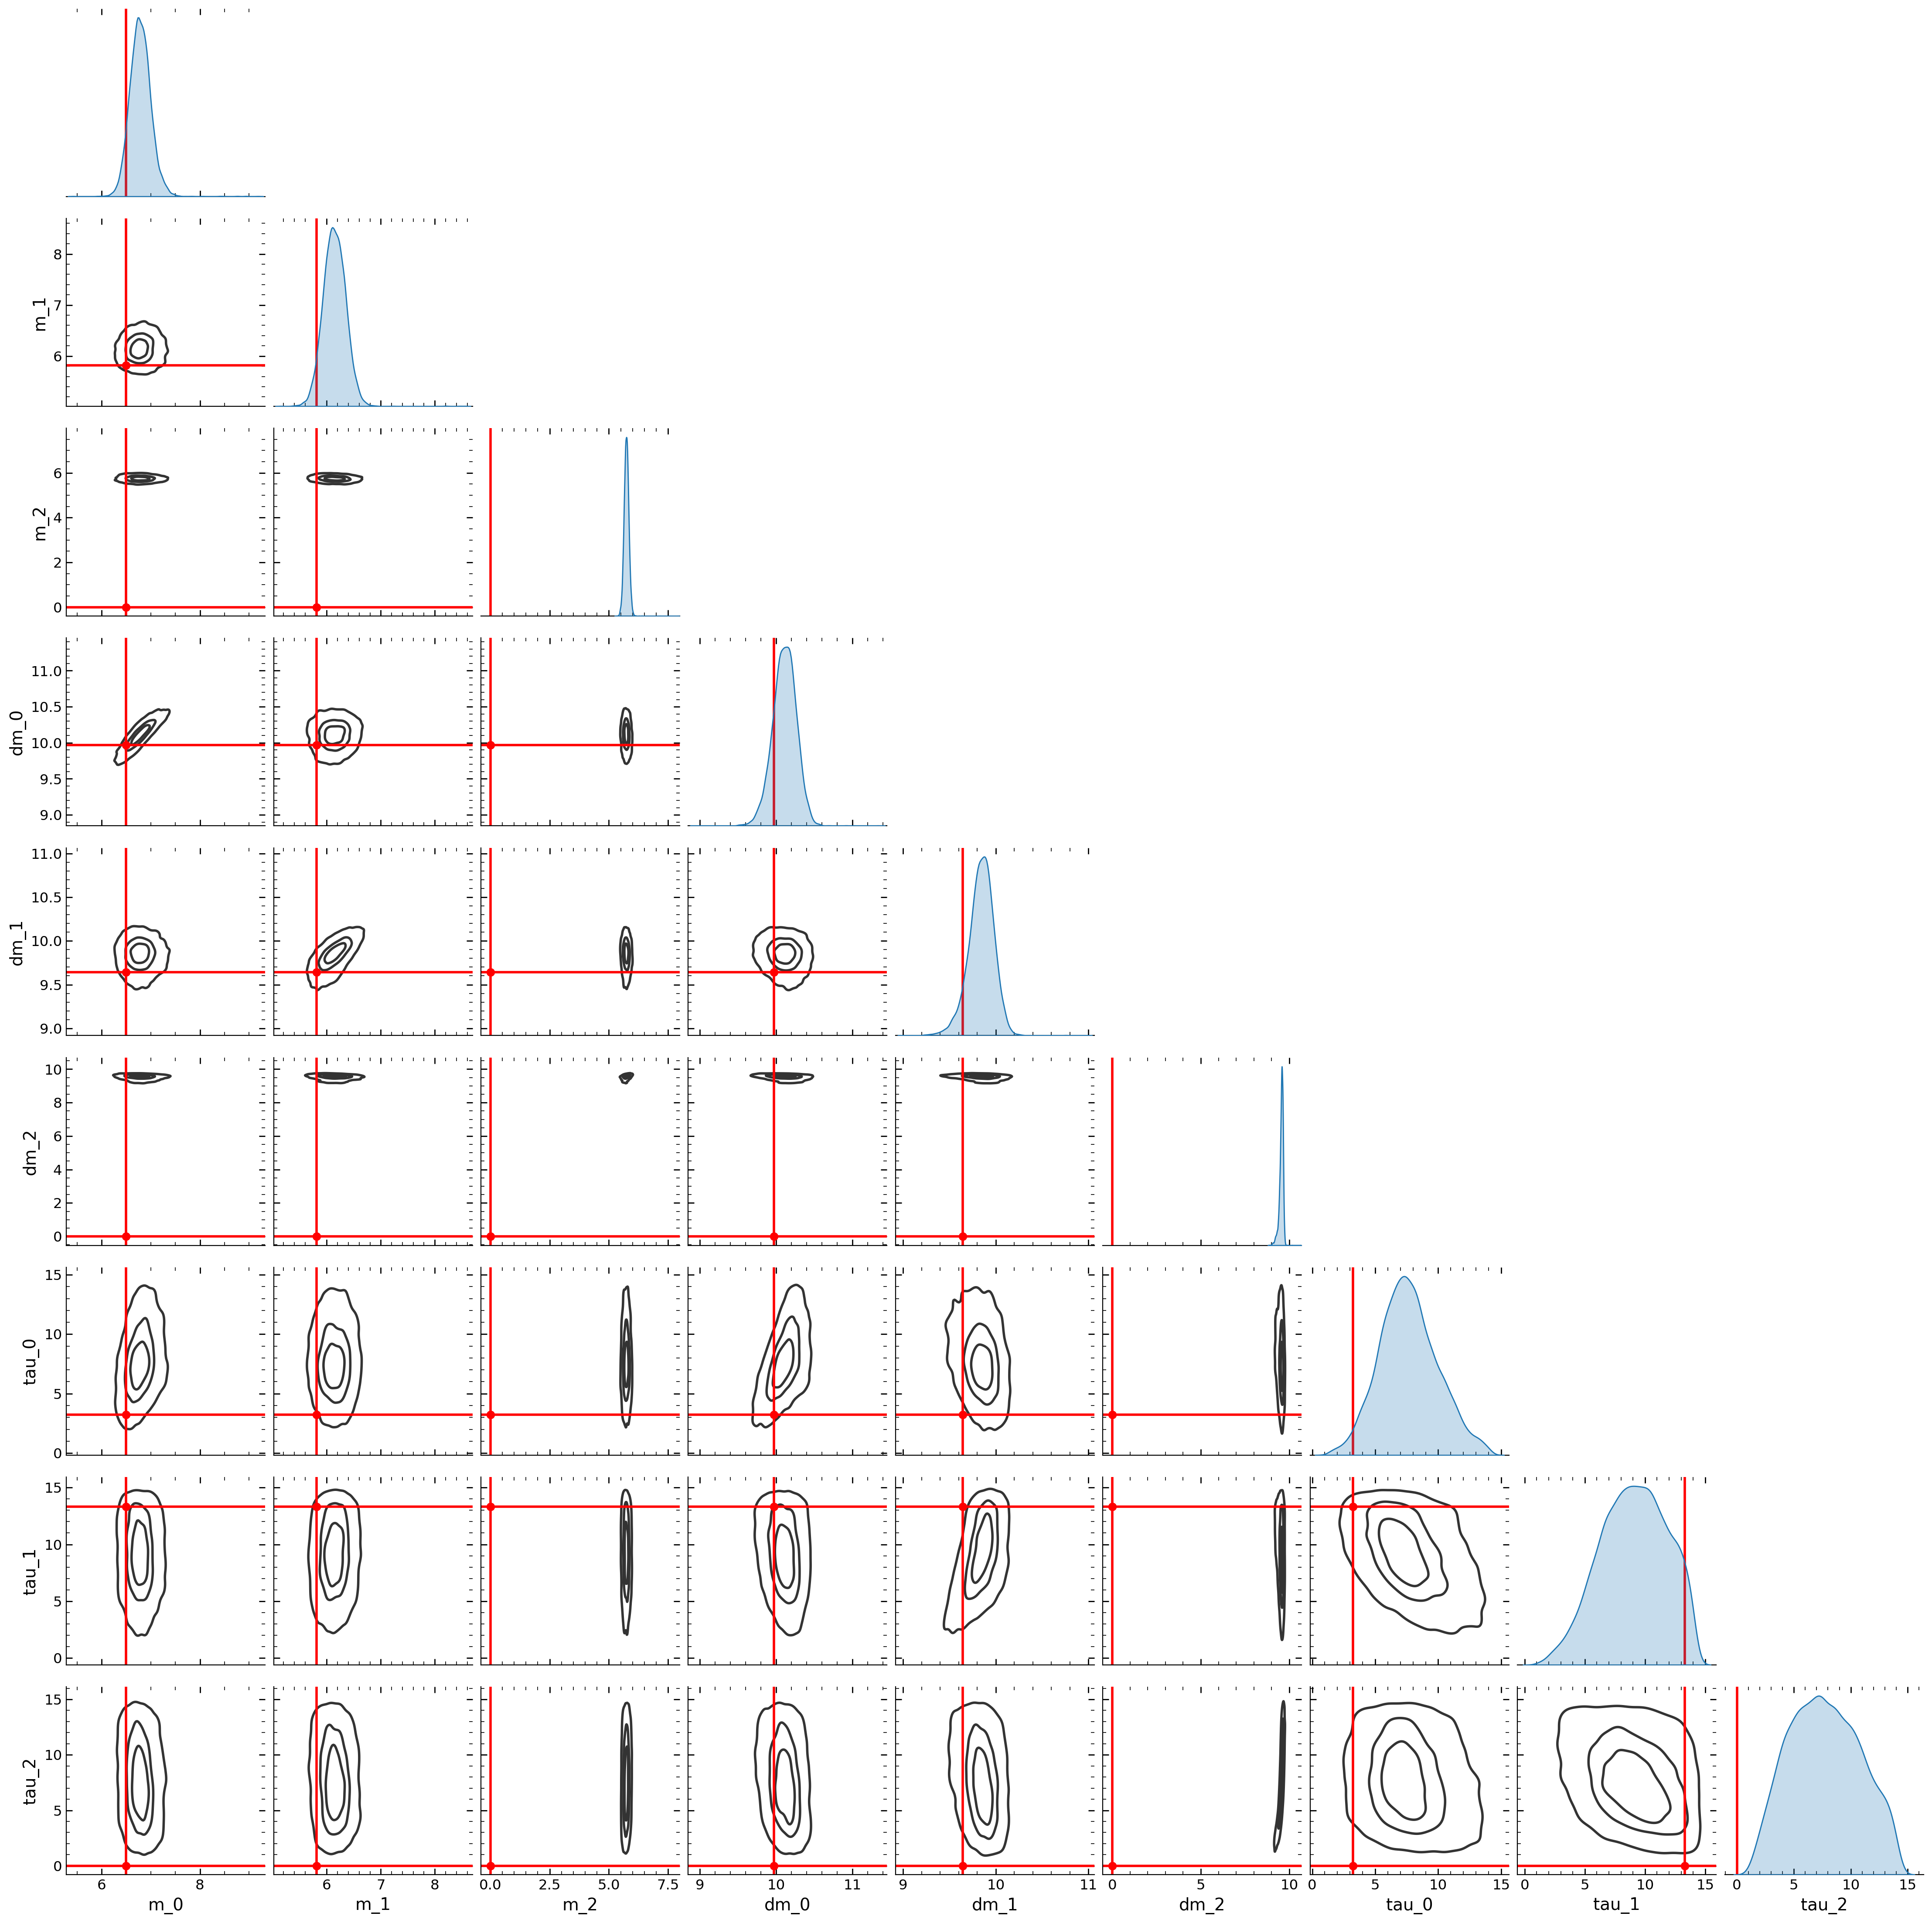

In [ ]:
#select only the first N subhalos from the inference 
inference_N_subhalos=np.load(os.path.join(inference_dir, 'inference_N_subhalos.npy'))
inference_parameters = np.load(os.path.join(inference_dir, 'inference_theta.npy'))
if inference_N_subhalos > round(samples.mean().item()):
    inference_parameters = inference_parameters.reshape((3, inference_N_subhalos))
    inference_parameters = inference_parameters[:, :round(samples.mean().item())].reshape(-1)
else:
    inference_parameters = inference_parameters.reshape((3, inference_N_subhalos.item()))
    inference_parameters = np.hstack((inference_parameters, np.zeros((3, round(samples.mean().item()) - inference_N_subhalos.item())))).reshape(-1)

labels = np.array([[f'm_{i}', f'dm_{i}', f'tau_{i}'] for i in range(round(samples.mean().item()))] )
labels = labels.T.reshape(-1)

np.save(os.path.join(inference_dir, 'inference_theta_Nsubahalosinfo.npy'), inference_parameters)

#evaluate posterior
fig = evaluate_posterior(posterior, 
                         observation_path=os.path.join(inference_dir, 'inference_x.npy'), parameter_path=os.path.join(inference_dir, 'inference_theta_Nsubahalosinfo.npy'),
                         labels=labels, n_samples=10_000)

100%|██████████| 100/100 [00:07<00:00, 12.69it/s]


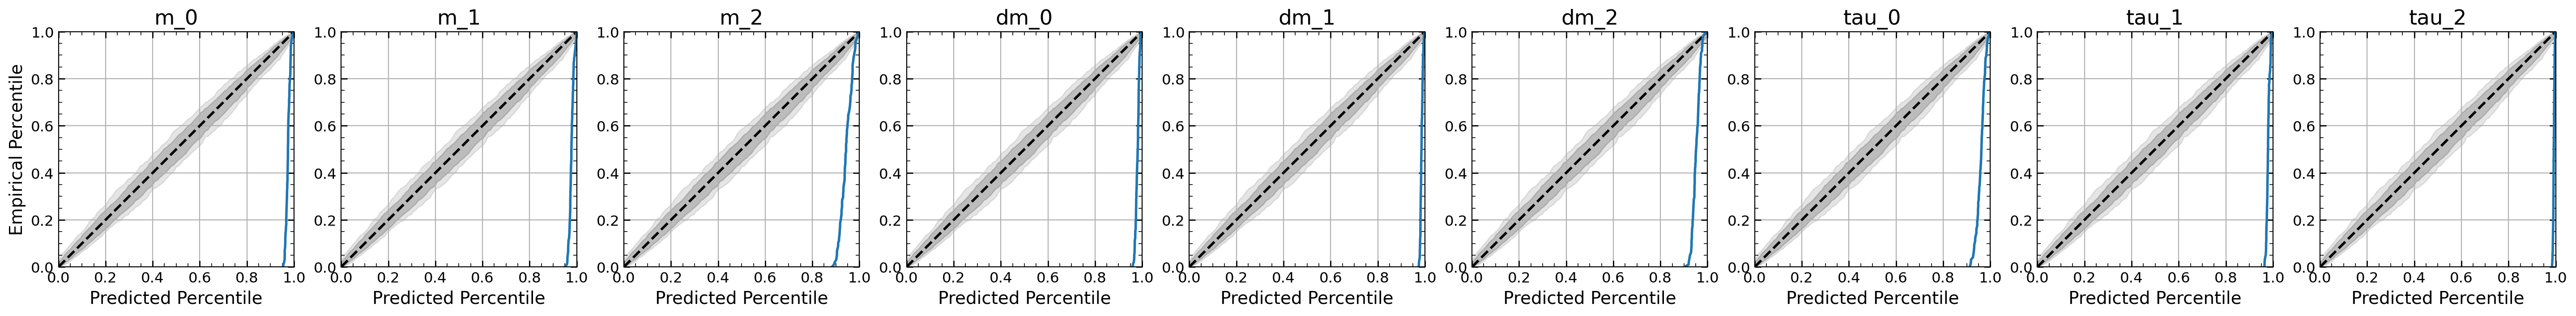

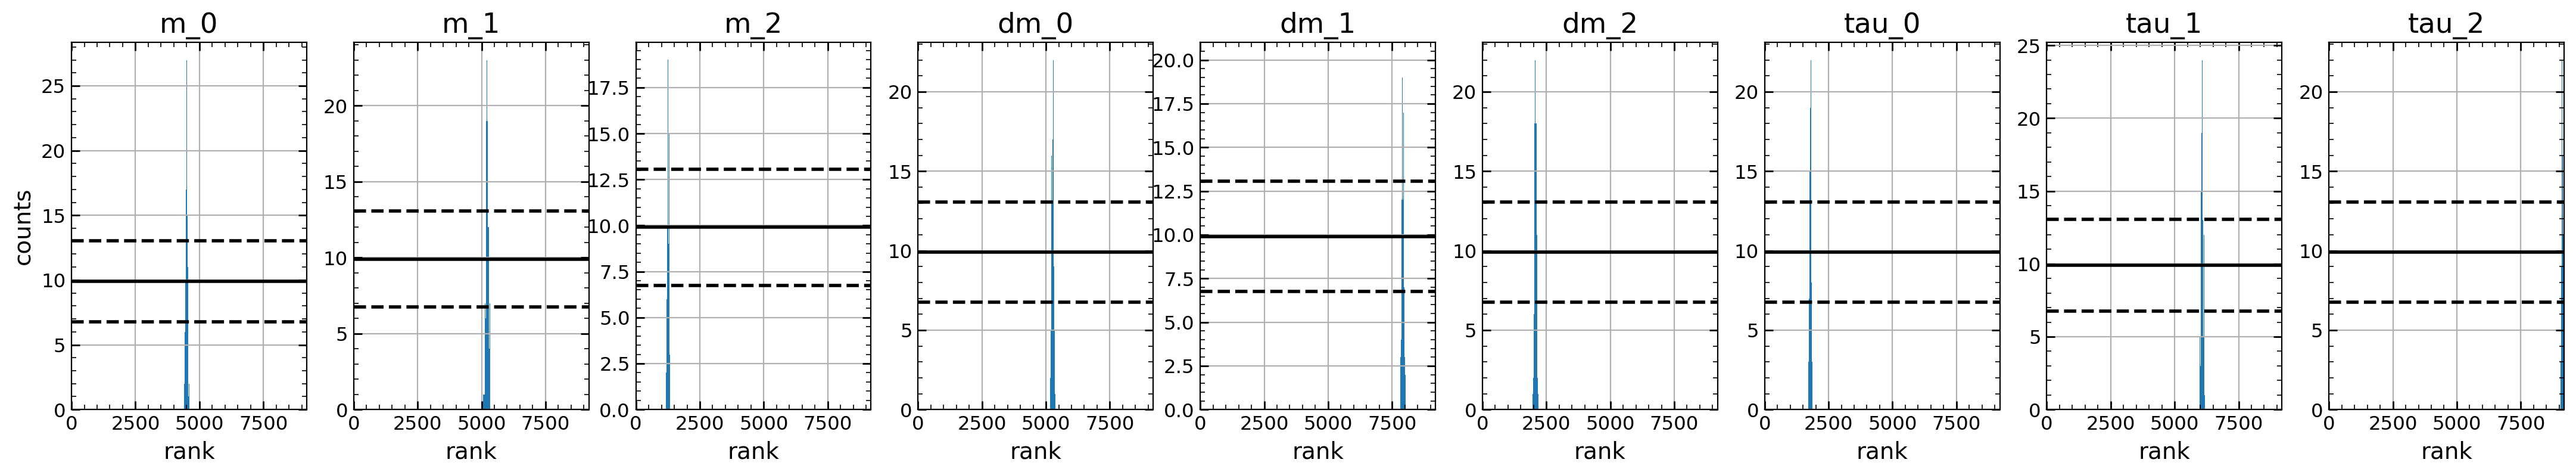

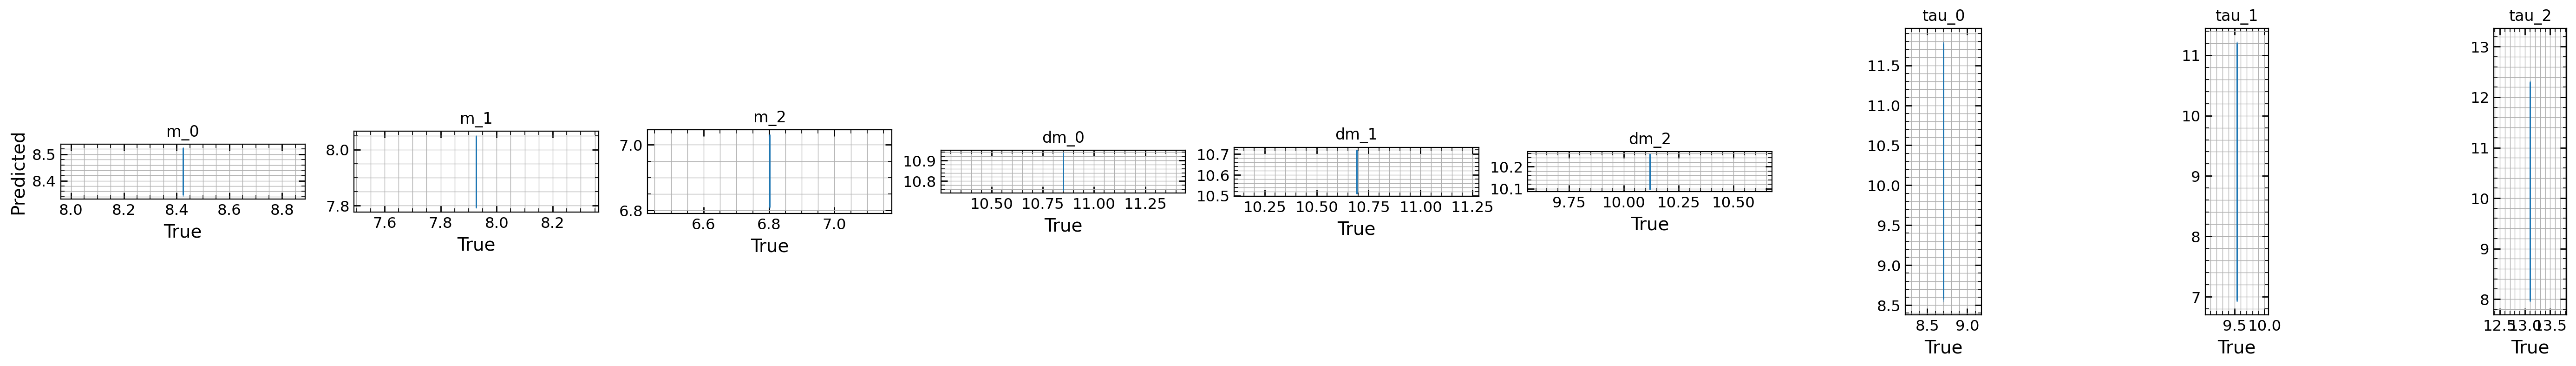

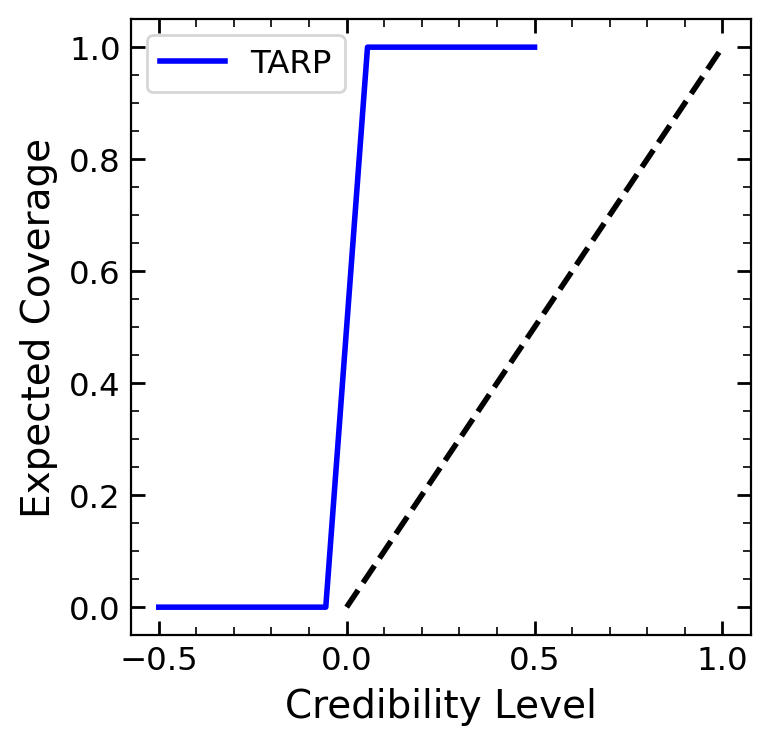

In [42]:
fig = calibrarion(posterior=posterior, 
                  observation_test_path=os.path.join(inference_dir, 'data/x_test.npy'), 
                  parameter_test_path=os.path.join(inference_dir, 'data/theta_test.npy'), 
                  n_samples=10_000, labels=labels)